In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing libraries We are going to use.

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This Part Is for analyzing data's.
Here as the result shows, we have approximately a unique 
vin, for each car, so it can't be useful in our learning. So we are not 
going to consider this column in our solution.
'State' & 'Make' have limited number of data, so we make a column for them that 
can only contain 2 values, 0 and 1.(One-Hot-Encod)
And we also do one-hot-encodeing for years too.

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv')
print('Records: ', len(df))
print('Model: ', df['Model'].nunique())
print('State: ', df['State'].nunique())
print('City: ', df['City'].nunique())
print('Make: ', df['Make'].nunique())
print('Year: ', df['Year'].nunique())
print('Vin: ', df['Vin'].nunique())

Records:  100000
Model:  2094
State:  59
City:  2524
Make:  56
Year:  22
Vin:  99999


Here we define some functions and some values for the class.
#one_hot_encode:#
this function is for setting a value for each unique value of non-numeric columns and store that number for that value in a dictionary.(we also store this dictionaries in a dictionary)

#one_hot_decode:#
this function is for getting each non-numeric value of a single column, and assign a number to that.(the value that we stored in a dictionary in previous part)

#convert_to_numeric:#
This function is for converting all non-numeric column to numeric columns by using one one_hot_encode & one_hot_decode functions that we explained befor.

#normalize:#
after we convert thoses columns to numeric, we Normalize all our columns (except thoses columns that are going to convert to a vector, 'State', 'Make')

#gradian_function:#
This Function is used for finding the gradin of the predicted price, and truth value of that price with it's definition.

#cost_function_simplified:#
Here, we define cost function and implement it's definition.

#convert_columns_to_Vector:#
As we mentioned befor, we are going to convert value of 2 columns, to vector.('State' & 'Make')
So for each of these 2 columns, we define number of unique values columns instead. e.g. we are going to define 56 columns for Satate ('State0', 'State1', ..., 'State58') and set value of any record one, if that column ('State') value is the same thing as the number of the new column (for example for 'State0', this number is 0) that we had given to each record of that column in one-hot-encode function, we set that record 1, othervise 0.

#LR_GD:#
this function repeat the update part epoch times and then return the weight that it achieves at the end.

#test:#
this function is for testing. We can devide train data in 2 different part and test this model and drowing plots, or we can use this method for making the final csv file.



In [5]:
class Linear_Regression:
  def __init__(self, x, target, columns, learning_rate, epoch, non_numeric_columns, convert_to_vector):
    self.columns = columns
    self.x = x
    self.target = target
    self.learning_rate = learning_rate
    self.epoch = epoch
    self.non_numeric_columns = non_numeric_columns
    self.non_numeric_dic = {}
    self.convert_to_vector = convert_to_vector
    self.convert_to_vector_value = {}
    self.final_columns = self.columns.copy()

  def one_hot_encode(self, dictionary, values):
    for x in values:
        if x not in dictionary.keys():
            dictionary[x] = len(dictionary)

  def one_hot_decode(self, dictionary, key):
    if key in dictionary.keys():
        return dictionary[key]
    dictionary[key] = len(dictionary)
    return dictionary[key]

  def convert_to_numeric(self):
    for i in self.non_numeric_columns:
      dictionary = {}
      self.non_numeric_dic[i] = dictionary
      self.one_hot_encode(dictionary, self.x[i].values)
      self.x[i] = [self.one_hot_decode(dictionary, j) for j in self.x[i].values]

  def normalize(self):
    self.normalize_dictionary = {}
    for i in self.final_columns:
      if i in self.convert_to_vector:
        continue
      mean = np.mean(self.x[i])
      var = np.var(self.x[i])
      self.x[i] = (self.x[i] - mean) / var
      self.normalize_dictionary[i] = {'mean':mean, 'var':var}
  
  def gradian_function(self, predict, w, x_vector):
    return np.dot(predict - self.target, x_vector) / len(x_vector)

  def cost_function_simplified(self, predicts):
    return np.sum((predicts - self.target) ** 2) / (2 * len(self.target))

  def convert_columns_to_Vector(self):
    for i in self.convert_to_vector:
      if i in self.final_columns:
        self.convert_to_vector_value[i] = self.x[i].nunique()
        self.final_columns.remove(i)
      count = self.convert_to_vector_value[i]
      for j in range(count):
        self.final_columns.append(i + str(j))
        self.x[i + str(j)] = np.where(self.x[i] == j, 1, 0)

  def LR_GD(self):
    self.convert_to_numeric()
    self.normalize()
    self.convert_columns_to_Vector()
    x_vector = self.x.loc[:, self.final_columns].to_numpy()
    print('Final Columns: ', self.final_columns)
    # Adding A New Column With Value 1, Just To Set The Bias Along Side With W
    bias = np.ones(len(self.x))
    x_vector = np.c_[x_vector, bias]
    w = [random.random() for x in range(len(self.final_columns) + 1)]
    # w = [random.random() for x in range(len(columns))]
    # w.append(np.mean(self.target))
    predict = np.dot(x_vector, w)
    costs = []
    cost = self.cost_function_simplified(predict)
    costs.append(cost)
    for i in range(self.epoch):
      gradian = self.gradian_function(predict, w, x_vector)
      w = w - (self.learning_rate * gradian)
      predict = np.dot(x_vector, w)
      predict = np.array(predict)
      cost = self.cost_function_simplified(predict)
      costs.append(cost)
    plt.plot([i for i in range(len(costs))], costs)
    plt.xlabel('Test Number')
    plt.ylabel('Cost Function')
    plt.title('Cost-Function-Result')
    plt.savefig("Cost-Function-Image.png")
    plt.show()
    return w

  def test(self, x_vector, target, w, show_plot = True, path = ''):
    for col in self.non_numeric_columns:
      dic = self.non_numeric_dic[col]
      x_vector[col] = [self.one_hot_decode(dic, i) for i in x_vector[col].values]

    for col in self.columns:
      if col in self.convert_to_vector:
        continue
      dic = self.normalize_dictionary[col]
      x_vector[col] = [(i - dic['mean']) / dic['var'] for i in x_vector[col]]

    for i in self.convert_to_vector:
      count = self.convert_to_vector_value[i]
      for j in range(count):
        x_vector[i + str(j)] = np.where(x_vector[i] == j, 1, 0)

    x_matrix = x_vector.loc[:, self.final_columns].to_numpy()
    bias_matrix = np.ones(len(x_vector))
    x_matrix = np.c_[x_matrix, bias_matrix]
    predict = np.absolute(np.dot(x_matrix, w))
    if not show_plot:
      df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/test.csv')
      df['Price'] = predict
      df.loc[:,['Price', 'CarId']].to_csv('/content/predict.csv', index = False)
      return
    plt.plot([x for x in range(len(target))], np.array(target), color='b')
    plt.plot([x for x in range(len(predict))], np.array(predict), color='r')
    plt.savefig('Test.png')
    plt.show()
    mins = [min(target), min(predict)]
    maxs = [max(target), max(predict)]
    plt.plot([min(mins), max(maxs)], [min(mins), max(maxs)])
    plt.scatter(predict, target)
    plt.xlabel('Predicted Price')
    plt.ylabel('Price')
    plt.savefig('Professional-Result.png')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Final Columns:  ['Mileage', 'City', 'Model', 'Year0', 'Year1', 'Year2', 'Year3', 'Year4', 'Year5', 'Year6', 'Year7', 'Year8', 'Year9', 'Year10', 'Year11', 'Year12', 'Year13', 'Year14', 'Year15', 'Year16', 'Year17', 'Year18', 'Year19', 'Year20', 'Year21', 'Make0', 'Make1', 'Make2', 'Make3', 'Make4', 'Make5', 'Make6', 'Make7', 'Make8', 'Make9', 'Make10', 'Make11', 'Make12', 'Make13', 'Make14', 'Make15', 'Make16', 'Make17', 'Make18', 'Make19', 'Make20', 'Make21', 'Make22', 'Make23', 'Make24', 'Make25', 'Make26', 'Make27', 'Make28', 'Make29', 'Make30', 'Make31', 'Make32', 'Make33', 'Make34', 'Make35', 'Make36', 'Make37', 'Make38', 'Make39', 'Make40', 'Make41', 'Make42', 'Make43', 'Make44', 'Make45', 'Make46', 'Make47', 'Make48', 'Make49', 'Make50', 'Make51', 'Make52', 'Make53', 'Make54', 'Make55', 'State0', 'State1', 'State2', 'State3', 'State4', 'State5', 'State6', 'State7', 'State8', 'State9', 'State10', 'State11', 'State12', 'State13', 'State14', 'State15', 'State16', 'State17', 'State1

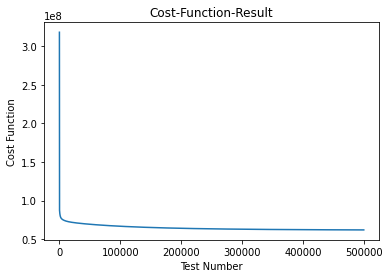

W:  [-1.23872749e+03  1.08325550e+03  2.11369098e+03  4.65420974e-01
  5.66068272e-01  4.07953332e-01  7.41576205e-01  7.21720368e-01
  6.77475184e-02  2.13918332e-01  4.49310234e-01  4.02900996e-01
  3.88004632e-03  7.81123302e-01  6.16839746e-01  5.86398397e-01
  6.58969545e-01  2.44358954e-01  6.69257049e-01  9.04144611e-01
  8.13327645e-01  8.80559708e-01  1.18473601e-01  5.92027339e-02
  6.92003328e-01 -1.36431272e+04 -1.32083774e+04 -1.89783642e+04
 -1.62702582e+04 -1.41562537e+04 -2.01304264e+04 -4.03150419e+03
 -1.96648050e+04 -9.54907604e+03 -1.87242684e+04 -1.59980327e+04
 -7.64058968e+03 -7.37253516e+03 -8.54371658e+03 -1.26754646e+04
 -1.98172848e+04 -2.06553851e+04 -1.19711083e+04 -2.67847742e+04
 -1.76689008e+04 -4.69552375e+03 -2.12380015e+04 -1.03906150e+04
 -1.66655825e+04  2.13876055e+04 -7.57103682e+03  6.67790297e+03
 -2.27761723e+04 -1.82741751e+04  1.61506070e+04 -2.32356976e+04
 -1.23691844e+04 -1.58874422e+04 -2.81537161e+04 -2.24088710e+04
 -2.89385587e+04 -2.6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


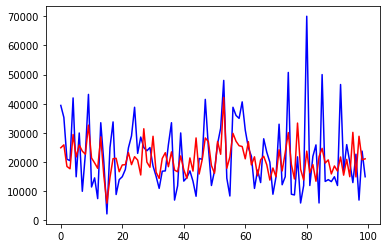

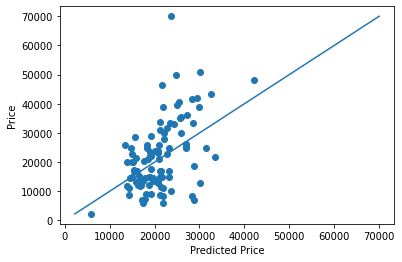

In [7]:
############################################# My Test #############################################
df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv')
test = df.iloc[99900:, :]
df = df.iloc[:99900, :]
# columns = ['Year', 'Mileage', 'City', 'State', 'Make', 'Model']
# non_numeric_columns = ['City', 'State', 'Make', 'Model']
# columns = ['Year', 'Mileage', 'State', 'Make', 'Model']
columns = ['Mileage', 'City', 'Model', 'Year', 'Make', 'State']
non_numeric_columns = ['City', 'Model', 'Make', 'State']
vectorize = ['Year', 'Make', 'State']
target = df['Price']
lr = Linear_Regression(df.loc[:,columns], target, columns, 0.018888885, 500000, non_numeric_columns, vectorize)
w = lr.LR_GD()
print('W: ', w)
lr.test(test.loc[:,columns], test.loc[:,['Price']].values, w)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Final Columns:  ['Mileage', 'City', 'Model', 'Year0', 'Year1', 'Year2', 'Year3', 'Year4', 'Year5', 'Year6', 'Year7', 'Year8', 'Year9', 'Year10', 'Year11', 'Year12', 'Year13', 'Year14', 'Year15', 'Year16', 'Year17', 'Year18', 'Year19', 'Year20', 'Year21', 'Make0', 'Make1', 'Make2', 'Make3', 'Make4', 'Make5', 'Make6', 'Make7', 'Make8', 'Make9', 'Make10', 'Make11', 'Make12', 'Make13', 'Make14', 'Make15', 'Make16', 'Make17', 'Make18', 'Make19', 'Make20', 'Make21', 'Make22', 'Make23', 'Make24', 'Make25', 'Make26', 'Make27', 'Make28', 'Make29', 'Make30', 'Make31', 'Make32', 'Make33', 'Make34', 'Make35', 'Make36', 'Make37', 'Make38', 'Make39', 'Make40', 'Make41', 'Make42', 'Make43', 'Make44', 'Make45', 'Make46', 'Make47', 'Make48', 'Make49', 'Make50', 'Make51', 'Make52', 'Make53', 'Make54', 'Make55', 'State0', 'State1', 'State2', 'State3', 'State4', 'State5', 'State6', 'State7', 'State8', 'State9', 'State10', 'State11', 'State12', 'State13', 'State14', 'State15', 'State16', 'State17', 'State1

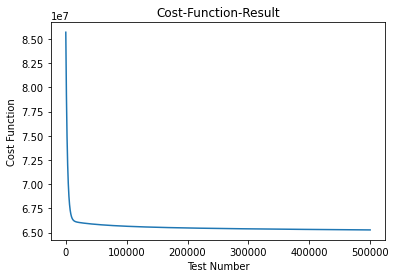

W:  [-2.64206382e+03  2.21872737e+02  8.14035871e+02  4.83025097e+03
  9.54147026e+03  9.00580022e+03  1.19964126e+04 -3.50346732e+03
  6.17362053e+03 -1.88967776e+03  3.60853032e+03  1.13426457e+03
  2.67285312e+02 -3.20457238e+03 -4.64902849e+03 -1.04076989e+02
  2.45514439e+03 -1.49452952e+03 -6.49112780e+03 -9.71496218e+02
 -4.02871909e+03  1.61574148e+04 -4.34988841e+03  2.39281955e+03
 -3.87150862e+03 -7.98120565e+03 -7.51239323e+03 -1.33241436e+04
 -1.06158424e+04 -8.50129812e+03 -1.45379185e+04  1.63674181e+03
 -1.39201826e+04 -3.63257570e+03 -1.30578573e+04 -1.05145894e+04
 -1.89456829e+03 -1.91057536e+03 -2.87627345e+03 -7.22514439e+03
 -1.42736930e+04 -1.50470838e+04 -6.76050081e+03 -1.24923872e+04
 -1.19779942e+04  6.57374929e+02 -1.55713263e+04 -4.63688420e+03
 -1.10480115e+04  2.70099848e+04 -1.96420937e+03  1.33619945e+04
 -1.98506111e+04 -1.25425018e+04  1.93603885e+04 -1.67509199e+04
 -6.63093426e+03 -2.95062492e+02 -1.29474963e+04 -1.72370420e+04
 -1.27797209e+04 -2.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [7]:
############################################# Upload #############################################
df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv')
target = df['Price']
test_path = '/content/drive/MyDrive/ML_HW2_Q1/test.csv'
test = pd.read_csv(test_path)
# columns = ['Year', 'Mileage', 'State', 'Make', 'Model']
# non_numeric_columns = ['State', 'Make', 'Model']
# vectorize = ['State', 'Make', 'Year']
#####   Best Answer  #####
# vectorize = ['State', 'Make']
# vectorize = ['City', 'State', 'Make', 'Model']

columns = ['Mileage', 'City', 'Model', 'Year', 'Make', 'State']
non_numeric_columns = ['City', 'Model', 'Make', 'State']
vectorize = ['Year', 'Make', 'State']
show_plot = False
#####   Best Answer  #####
lr = Linear_Regression(df.loc[:,columns], target, columns, 0.018888885, 500000, non_numeric_columns, vectorize)
w = lr.LR_GD()
print('W: ', w)
lr.test(test.loc[:,columns], [], w, show_plot, test_path)

In [ ]:
# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# def one_hot_encode(dictionary, df):
#     for x in df:
#         if x not in dictionary.keys():
#             dictionary[x] = len(dictionary)

# def one_hot_decode(dictionary, key):
#     if key in dictionary.keys():
#         return dictionary[key]
#     dictionary[key] = len(dictionary)
#     return dictionary[key]


# # def loss_function(predicted, target):
# #     return ((predicted - target) ** 2) / 2
# #
# # def cost_function(predicts, targets):
# #     return sum([loss_function(predicts[x], targets[x]) for x in range(len(targets))]) / len(targets)

# def cost_function_simplified(predicts, targets):
#     return np.sum((predicts - targets) ** 2) / (2 * len(targets))

# def gradian_function(predict, target, w, x_vector):
#     return np.dot(predict - target, x_vector) / len(x_vector)
#     # diff = predict - target
#     # gradian = np.dot(diff, x_vector)
#     # return gradian / len(x_vector)

# # df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv')
# df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv').iloc[:99900, :]

# # Converting Non Numeric Values To Numeric Values By Using one_hot_function
# city_rank = {}
# one_hot_encode(city_rank, df['City'])
# rank = [city_rank[x] for x in df['City']]
# city_mean = np.mean(rank)
# city_var = np.var(rank)
# df['City Rank'] = [(x - city_mean) / city_var for x in rank]

# state_rank = {}
# one_hot_encode(state_rank, df['State'])
# rank = [state_rank[x] for x in df['State']]
# state_mean = np.mean(rank)
# state_var = np.var(rank)
# df['State Rank'] = [(x - state_mean) / state_var for x in rank]

# # vin_rank = {}
# # one_hot_encode(vin_rank, df['Vin'])
# # rank = [vin_rank[x] for x in df['Vin']]
# # vin_mean = np.mean(rank)
# # vin_var = np.var(rank)
# # df['Vin Rank'] = [(x - vin_mean) / vin_var for x in rank]

# make_rank = {}
# one_hot_encode(make_rank, df['Make'])
# rank = [make_rank[x] for x in df['Make']]
# make_mean = np.mean(rank)
# make_var = np.var(rank)
# df['Make Rank'] = [(x - make_mean) / make_var for x in rank]

# model_rank = {}
# one_hot_encode(model_rank, df['Model'])
# rank = [model_rank[x] for x in df['Model']]
# model_mean = np.mean(rank)
# model_var = np.var(rank)
# df['Model Rank'] = [(x - model_mean) / model_var for x in rank]

# year_mean = np.mean(df['Year'])
# year_var = np.var(df['Year'])
# df['Year'] = [(x - year_mean) / year_var for x in df['Year']]

# mileage_mean = np.mean(df['Mileage'])
# mileage_var = np.var(df['Mileage'])
# df['Mileage'] = [(x - mileage_mean) / mileage_var for x in df['Mileage']]


# # columns = ['Year', 'Mileage', 'City Rank', 'State Rank', 'Vin Rank', 'Make Rank', 'Model Rank']
# columns = ['Year', 'Mileage', 'City Rank', 'State Rank', 'Make Rank', 'Model Rank']
# x_vector = df.loc[:, columns].to_numpy()

# # Adding A New Column With Value 1, Just To Set The Bias Along Side With W
# bias = np.ones(len(df))
# x_vector = np.c_[x_vector, bias]
# # print('x_vector:')
# # print(x_vector[0])

# target = np.array(df.iloc[:,0].values)
# # target_mean = np.mean(target)
# # target_var = np.var(target)
# # target = (target - target_mean) / target_var
# # print('target:')
# # print(target)

# learning_rate = 0.0015
# epoch = 30000

# # Setting The Bias Number In This Vector Along Side Of Xi
# # w = [((random.random() * 1)) for x in range(len(columns) + 1)]
# w = [((random.random() * 1) + 0) for x in range(len(columns) + 1)]
# # w = [((random.random() * 1) + 0) for x in range(len(columns))]
# # w.append(np.mean(df['Price']))
# # w.append(np.mean(df['Price']))
# # w.append(1)
# # w.append(df['Price'].mean())
# # w = [1 for x in range(len(columns) + 1)]
# # print('W:')
# # print(w)


# predict = np.dot(x_vector, w)
# # print('predict:')
# # print(predict)
# cost = cost_function_simplified(predict, target)
# # print('cost:')
# # print(cost)

# coasts = []
# for i in range(epoch):
#     gradian = gradian_function(predict, target, w, x_vector)
#     w = w - (learning_rate * gradian)
#     # print('New W:')
#     # print(w)
#     predict = np.dot(x_vector, w)
#     # print('Predict:')
#     # print(predict)
#     cost = cost_function_simplified(predict, target)
#     # print('cost:')
#     # print(cost)
#     coasts.append(cost)

# x = [i for i in range(len(coasts))]
# # plt.plot(x, coasts, marker = 'o', mec = 'r', mfc = 'r', linestyle  = "--")
# plt.plot(x, coasts)
# plt.xlabel('Test Number')
# plt.ylabel('Cost Function')
# plt.title('Cost Function Result')
# plt.savefig("Loss-Function-Plot.png")
# plt.show()


# ###################################################################
# ##############         My Test          ####################
# df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/train.csv').iloc[99900:, :]

# # Converting Non Numeric Values To Numeric Values By Using rank function
# df['City Rank'] = [(one_hot_decode(city_rank, x) - city_mean) / city_var for x in df['City']]
# # df['City Rank'] = [one_hot_decode(city_rank, x) for x in df['City']]
# # df['City Rank'] = [(x - np.mean(df['City Rank'])) / np.var(df['City Rank']) for x in df['City Rank']]
# df['State Rank'] = [(one_hot_decode(state_rank, x) - state_mean) / state_var for x in df['State']]
# # df['State Rank'] = [one_hot_decode(state_rank, x) for x in df['State']]
# # df['State Rank'] = [(x - np.mean(df['State Rank'])) / np.var(df['State Rank']) for x in df['State Rank']]
# # df['Vin Rank'] = [(one_hot_decode(vin_rank, x) - vin_mean) / vin_var for x in df['Vin']]
# df['Make Rank'] = [(one_hot_decode(make_rank, x) - make_mean) / make_var for x in df['Make']]
# # df['Make Rank'] = [one_hot_decode(make_rank, x) for x in df['Make']]
# # df['Make Rank'] = [(x - np.mean(df['Make Rank'])) / np.var(df['Make Rank']) for x in df['Make Rank']]
# df['Model Rank'] = [(one_hot_decode(model_rank, x) - model_mean) / model_var for x in df['Model']]
# # df['Model Rank'] = [one_hot_decode(model_rank, x) for x in df['Model']]
# # df['Model Rank'] = [(x - np.mean(df['Model Rank'])) / np.var(df['Model Rank']) for x in df['Model Rank']]

# df['Year'] = [(x - year_mean) / year_var for x in df['Year']]

# df['Mileage'] = [(x - mileage_mean) / mileage_var for x in df['Mileage']]

# test_x = df.loc[:, columns].to_numpy()
# test_bias = np.ones(len(df))
# test_x = np.c_[test_x, test_bias]

# df['Predicted Price'] = np.dot(test_x, w)
# # df['Predicted Price'] = [abs(x) for x in df['Predicted Price']]
# # df['Predicted Price'] = [(x * target_var) + target_mean for x in df['Predicted Price']]

# print('Total Predicted Price:')
# print(df['Predicted Price'].to_string())
# print('w:')
# print(w)
# print('x_vector:')
# print(test_x)

# plt.subplot(211)
# plt.plot(df['Price'])
# plt.subplot(212)
# plt.plot(df['Predicted Price'])
# plt.show()

# plt.plot([x for x in range(len(df))], np.array(df.iloc[:,0].values), color='b')
# plt.plot([x for x in range(len(df))], np.array(df.loc[:,['Predicted Price']].values), color='r')
# plt.savefig('My Test On 10 Test date.png')
# plt.show()
# # print('Target Mean:')
# # print(target_mean)
# # print('Target Var:')
# # print(target_var)
# mins = [min(df['Predicted Price']), min(df['Price'])]
# maxs = [max(df['Predicted Price']), max(df['Price'])]
# plt.plot([min(mins), max(maxs)], [min(mins), max(maxs)])
# plt.scatter(df['Predicted Price'], df['Price'])
# plt.xlabel('Predicted Price')
# plt.ylabel('Price')
# plt.savefig('Professional-Result.png')
# plt.show()
# print('Cost:')
# print(cost_function_simplified(df['Predicted Price'], df['Price']))
# exit(0)
# ###################################################################
# # df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/test.csv')
# # # just in case that we can see the result, if we get all test.csv file, we get error of merror space due to its huge size
# # # df = pd.read_csv('/content/train.csv')

# # # Converting Non Numeric Values To Numeric Values By Using rank function
# # df['City Rank'] = [(one_hot_decode(city_rank, x) - city_mean) / city_var for x in df['City']]
# # df['State Rank'] = [(one_hot_decode(state_rank, x) - state_mean) / state_var for x in df['State']]
# # # df['Vin Rank'] = [(one_hot_decode(vin_rank, x) - vin_mean) / vin_var for x in df['Vin']]
# # df['Make Rank'] = [(one_hot_decode(make_rank, x) - make_mean) / make_var for x in df['Make']]
# # df['Model Rank'] = [(one_hot_decode(model_rank, x) - model_mean) / model_var for x in df['Model']]


# # # df['City Rank'] = [one_hot_decode(city_rank, x) for x in df['City']]
# # # df['State Rank'] = [one_hot_decode(state_rank, x) for x in df['State']]
# # # # df['Vin Rank'] = [(one_hot_decode(vin_rank, x) - vin_mean) / vin_var for x in df['Vin']]
# # # df['Make Rank'] = [one_hot_decode(make_rank, x) for x in df['Make']]
# # # df['Model Rank'] = [one_hot_decode(model_rank, x) for x in df['Model']]

# # # mean = np.mean(df['City Rank'])
# # # var = np.var(df['City Rank'])
# # # df['City Rank'] = [(x - mean) / var for x in df['City Rank']]
# # # mean = np.mean(df['State Rank'])
# # # var = np.var(df['State Rank'])
# # # df['State Rank'] = [(x - mean) / var for x in df['State Rank']]
# # # mean = np.mean(df['Make Rank'])
# # # var = np.var(df['Make Rank'])
# # # df['Make Rank'] = [(x - mean) / var for x in df['Make Rank']]
# # # mean = np.mean(df['Model Rank'])
# # # var = np.var(df['Model Rank'])
# # # df['Model Rank'] = [(x - mean) / var for x in df['Model Rank']]
# # # df['Vin Rank'] = [(one_hot_decode(vin_rank, x) - vin_mean) / vin_var for x in df['Vin']]


# # df['Year'] = [(x - year_mean) / year_var for x in df['Year']]

# # df['Mileage'] = [(x - mileage_mean) / mileage_var for x in df['Mileage']]

# # # print(df.head().to_string())

# # # columns = ['Year', 'Mileage', 'City Rank', 'State Rank', 'Vin Rank', 'Make Rank', 'Model Rank']
# # test_x = df.loc[:, columns].to_numpy()
# # test_bias = np.ones(len(df))
# # test_x = np.c_[test_x, test_bias]

# # df['Price'] = np.dot(test_x, w)
# # # print(df.to_string())
# # # res_df = pd.read_csv('/content/drive/MyDrive/ML_HW2_Q1/test.csv')
# # # res_df['Price'] = df['Price']
# # # print(res_df.to_string())
# # df.loc[:,['Price', 'CarId']].to_csv('/content/predict.csv', index = False)



# ########################### SK_Learn #####################
# # df = pd.read_csv('/content/train.csv')
# # non_numeric = ['Model', 'Make', 'Vin', 'State', 'City']
# # df['Model'] = [one_hot_decode(model_rank, x) for x in df['Model']]
# # df['Make'] = [one_hot_decode(make_rank, x) for x in df['Make']]
# # df['Vin'] = [one_hot_decode(vin_rank, x) for x in df['Vin']]
# # df['State'] = [one_hot_decode(state_rank, x) for x in df['State']]
# # df['City'] = [one_hot_decode(city_rank, x) for x in df['City']]
# # from sklearn.linear_model import LinearRegression
# # lr_model = LinearRegression()
# # lr_model.fit(df.iloc[:,1:], df.iloc[:,0])
# # w = lr_model.coef_
# # b = lr_model.intercept_
# # df['Predicted-Price'] = np.dot(df.iloc[:,1:], w) + b
# # mins = [min(df['Price']), min(df['Predicted-Price'])]
# # maxs = [max(df['Price']), max(df['Predicted-Price'])]
# # plt.plot([min(mins), max(maxs)], [min(mins), max(maxs)])
# # plt.scatter(df['Price'], df['Predicted-Price'])
# # plt.title('AAAAAAAAAAAAAAAAAAAAAAAA')
# # plt.xlabel('Price')
# # plt.ylabel('sk_learn Price')
# # plt.savefig('sk_learn-MyPredict.png')
# # plt.show()
# # test_df = pd.read_csv('/content/test.csv')
# # test_df['Model'] = [one_hot_decode(model_rank, x) for x in test_df['Model']]
# # test_df['Make'] = [one_hot_decode(make_rank, x) for x in test_df['Make']]
# # test_df['Vin'] = [one_hot_decode(vin_rank, x) for x in test_df['Vin']]
# # test_df['State'] = [one_hot_decode(state_rank, x) for x in test_df['State']]
# # test_df['City'] = [one_hot_decode(city_rank, x) for x in test_df['City']]

# # test_df['Price'] = np.dot(test_df.iloc[:,1:], w) + b
# # mins = [min(res_df['Price']), min(test_df['Price'])]
# # maxs = [max(res_df['Price']), max(test_df['Price'])]
# # plt.plot([min(mins), max(maxs)], [min(mins), max(maxs)])
# # plt.scatter(res_df['Price'], test_df['Price'])
# # plt.xlabel('My Price')
# # plt.ylabel('sk_learn Price')
# # plt.savefig('sk_learn-MyPredict.png')
# # plt.show()

TypeError: ignored